In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models.resnet as resnet
import os

In [2]:
%matplotlib inline

In [3]:
model = resnet.resnet18()
model.load_state_dict(torch.load('pytorch_pretrained_resnet_model_80e'))
model = model.eval()

In [4]:
model = resnet.resnet18(pretrained=True).eval()

The paper visualized neurons via two methods: looking at the kernels, and using gradient ascent to create an image to maximize the score of a particular artist.

In [5]:
blocks = [*model.layer1, *model.layer2, *model.layer3, *model.layer4]

layers = [[b.conv1, b.conv2] for b in blocks]

layers = [l for group in layers for l in group]

In [6]:
weights = layers[0].weight.detach()

In [7]:
weights.size()

torch.Size([64, 64, 3, 3])

In [8]:
layers[-1]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [ ]:
# fig, axarr = plt.subplots(weights[0].size(0))
# WIP to get this working again
# for i in range(weights[0].size(0)):
#     axarr[i].imshow(weights[0, i].squeeze())
    


## Gradient Ascent

In [9]:
import os
import cv2
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models.resnet as resnet
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from PIL import Image
import art_identify.common_utils

label_to_artist, artist_to_label = common_utils.init_label_dicts()

model = resnet.resnet18()
model.load_state_dict(torch.load('pytorch_pretrained_resnet_model_80e'))

<All keys matched successfully>

In [10]:
def preprocess(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    im_arr = np.float32(image)
    im_arr = im_arr.transpose(2, 0 ,1)
    
    im_arr /= 255
    for channel in range(len(im_arr)):
        im_arr[channel] -= mean[channel]
        im_arr[channel] /= std[channel]
    im_tensor = torch.from_numpy(im_arr).cuda().float()
    
    im_tensor.unsqueeze_(0)
    im_var = Variable(im_tensor, requires_grad=True)
    return im_var

def denormalize(image):
    r_mean = [-0.485, -0.456, -0.406]
    r_std = [1/0.229, 1/0.224, 1/0.225]
    recreated = copy.copy(image.numpy()[0])
    for channel in range(len(recreated)):
        recreated[channel] /= r_std[channel]
        recreated[channel] -= r_mean[channel]
    recreated = np.round(recreated * 255)
    recreated = np.uint8(recreated).transpose(1,2,0)
    return recreated

In [11]:
def generate_random_image(size=224):
    return Image.fromarray(
        np.uint8(np.random.uniform(110, 190, (size, size, 3)))
    )

In [12]:
artist = 'Pablo Picasso'
size = 224
lr = 0.1
reg_term = 0.1
label_to_artist, artist_to_label = common_utils.init_label_dicts()
label = artist_to_label[artist]

/home/cole/miniconda3/envs/sci/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


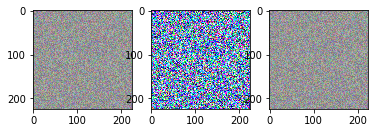

In [13]:
label = 130
model = model.cuda().eval()
img = generate_random_image(size=size)
preprocessed = preprocess(img).detach().cpu().numpy().squeeze().transpose(1,2,0)
recreated = denormalize(torch.tensor(preprocess(img).cpu()))

fig, ax_arr = plt.subplots(1,3)
ax_arr[0].imshow(img)
ax_arr[1].imshow(preprocessed)
ax_arr[2].imshow(recreated);

In [14]:

img_var = preprocess(img)
optimizer = torch.optim.Adam([img_var], lr=0.5, weight_decay=1e-2)
for n in range(500):
    optimizer.zero_grad()
    outputs = model(img_var)
    loss = -outputs[0, label]
    model.zero_grad()
    loss.backward()
    if n == 0 or n % 50 == 0:
        print(loss)
    optimizer.step()
img = img_var.detach().cpu()

tensor(14.3772, device='cuda:0', grad_fn=<NegBackward>)
tensor(6.4960, device='cuda:0', grad_fn=<NegBackward>)
tensor(6.4202, device='cuda:0', grad_fn=<NegBackward>)
tensor(5.8464, device='cuda:0', grad_fn=<NegBackward>)
tensor(6.8644, device='cuda:0', grad_fn=<NegBackward>)
tensor(6.1920, device='cuda:0', grad_fn=<NegBackward>)
tensor(6.8412, device='cuda:0', grad_fn=<NegBackward>)
tensor(6.6126, device='cuda:0', grad_fn=<NegBackward>)
tensor(6.4052, device='cuda:0', grad_fn=<NegBackward>)
tensor(6.7127, device='cuda:0', grad_fn=<NegBackward>)


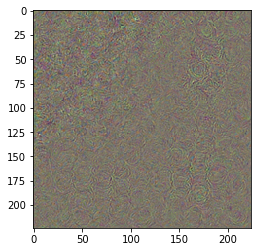

In [20]:
plt.imshow(denormalize(img_var.detach().cpu()));
plt.imsave('picasso.png', denormalize(img_var.detach().cpu()))